In [1]:
import os
import shutil
from pathlib import Path

import pyvista as pv
import ogstools as ot
import ogstools.variables as ov

import matplotlib.pyplot as plt
import numpy as np

from meshing import create_rectangle_mesh, create_cube_mesh, create_rectangle_frac_mesh

In [2]:
#verifying path origin
os.getcwd()

'/Volumes/Projects/Decovalex/FAULT/Getting_started_OGS\xa0'

# Path

In [3]:
OGS_PATH = None

In [4]:
if OGS_PATH is not None:
    os.environ["OGS_BIN_PATH"] = OGS_PATH
OUT_DIR = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
MESH_DIR = OUT_DIR / "mesh"
shutil.rmtree(OUT_DIR, ignore_errors=True)
MESH_DIR.mkdir(parents=True, exist_ok=True)

# 2D mesh generation

In [5]:
MSH_FILE = MESH_DIR / "rectangle_2d.msh"

create_rectangle_mesh(
        MSH_FILE,
        width=10.0,
        height=10.0,
        mesh_size=1.0,
        center_z=-20.0)

meshes = ot.meshes_from_gmsh(MSH_FILE, log=False)
for name, mesh in meshes.items():
    vtu_path = MESH_DIR / f"{name}.vtu"
    pv.save_meshio(vtu_path, mesh)
    print(f"Saved {vtu_path}")



Saved _out/mesh/domain.vtu
Saved _out/mesh/physical_group_top.vtu
Saved _out/mesh/physical_group_left.vtu
Saved _out/mesh/physical_group_bottom.vtu
Saved _out/mesh/physical_group_right.vtu
Saved _out/mesh/physical_group_domain.vtu


## 2D mesh Plot 

/var/folders/r9/xlx2ppvs42n_h9_kk4w3r57m0000gp/T/ipykernel_86509/1801929542.py:26: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


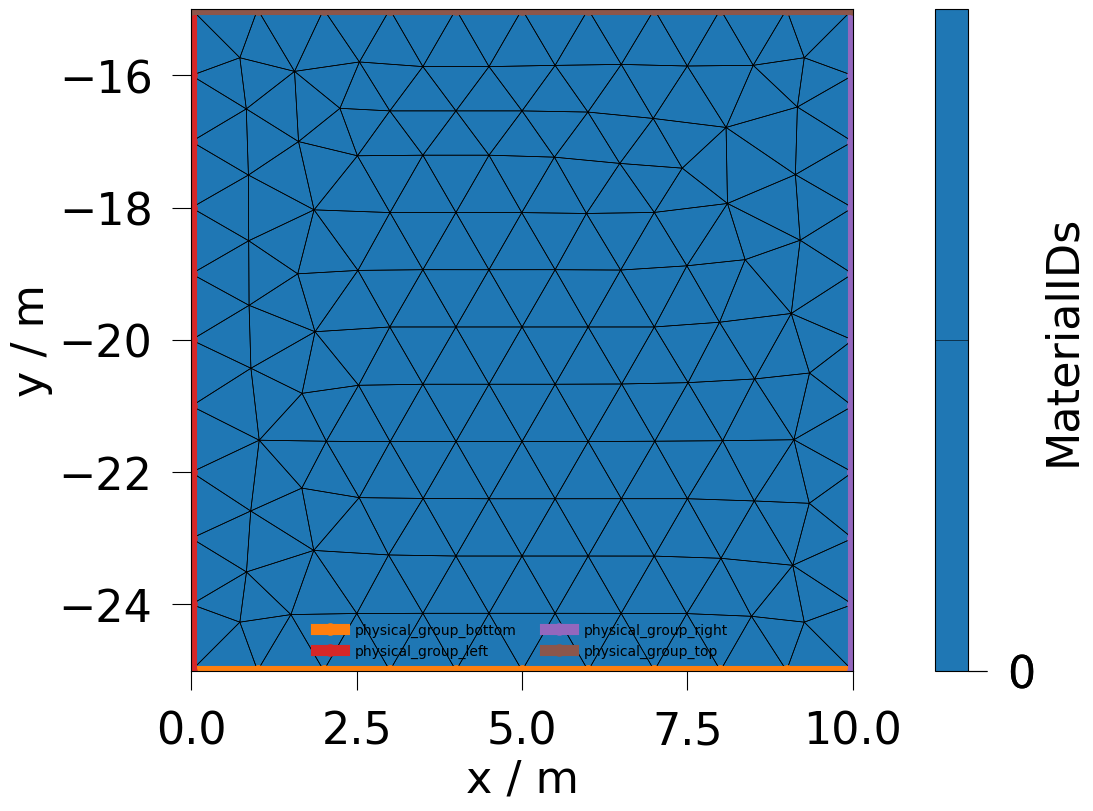

In [6]:
fig = meshes["domain"].plot_contourf(
    "MaterialIDs",
    figsize=(12, 8),
    dpi=100,
    cmap="tab20",
    alpha=0.3,
    linewidth=0,
)
ax = fig.axes[0]
for i, (name, mesh) in enumerate(sorted(meshes.items())):
    if mesh.area:  
        continue
    ls, marker = ("-", "") if "boundary" in name else ("-", "o")
    ot.plot.line(
        mesh,
        ax=ax,
        color=f"C{i}",
        lw=2,
        ls=ls,
        marker=marker,
        markersize=8,
        label=name,
    )
ax.set_aspect("equal")
ax.legend(ncol=2, fontsize=10, frameon=False)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

## 2D OGS and Python plot results

In [7]:
!NodeReordering -o ./_out/mesh/domain.vtu -i ./_out/mesh/domain.vtu 

[2025-08-04 14:44:19.649] [ogs] [info] Reordering nodes... 
[2025-08-04 14:44:19.650] [ogs] [info] Corrected 0 elements.
[2025-08-04 14:44:19.651] [ogs] [info] VTU file written.


In [8]:
!ogs SD_init.prj -m ./_out/mesh -o ./_out/

info: OGS started on 2025-08-04 14:44:19+0200 in serial mode.
info: This is OpenGeoSys-6 version 6.5.5-152-g476ff5cf. Log version: 2, Log level: info.
info: Eigen use 1 threads
info: Reading project file SD_init.prj.
info: readRasters ...
info: readRasters done
info: ConstantParameter: E
info: ConstantParameter: nu
info: ConstantParameter: displacement0
info: ConstantParameter: zero
info: ConstantParameter: T0
info: FunctionParameter: sigma0
info: FunctionParameter: geo_stress
info: No source terms for process variable 'displacement' found.
info: Threads used for ParallelVectorMatrixAssembler: 1. This is the default when OGS_ASM_THREADS environment variable is not set.
info: SmallDeformation process initializeSubmeshOutput().
info: Initialize processes.
info: Time step #0 started. Time: 0. Step size: 0.
info: [time] Output of timestep 0 took 0.006941 s.
info: Time step #0 took 0.007509 s.
info: Solve processes.
info: Time step #1 started. Time: 10. Step size: 10.
info: Solving process 

In [9]:
ms = ot.MeshSeries(f'{OUT_DIR}/init.pvd')
mesh = ms[-1]

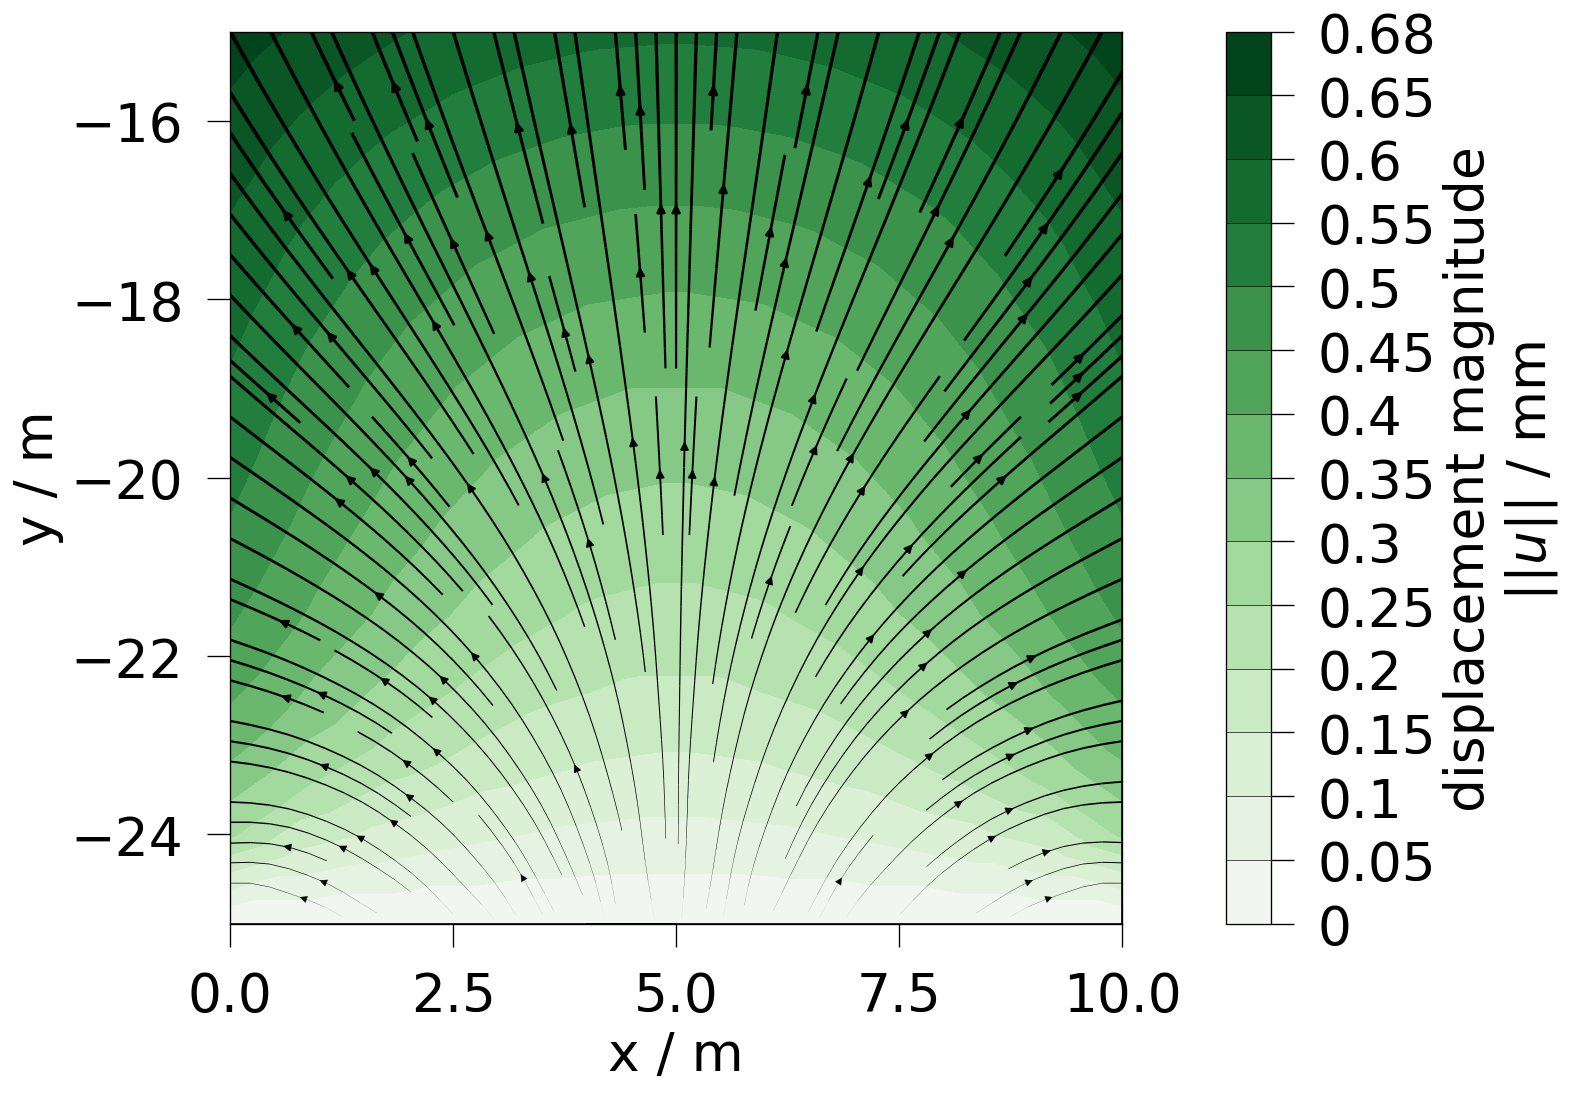

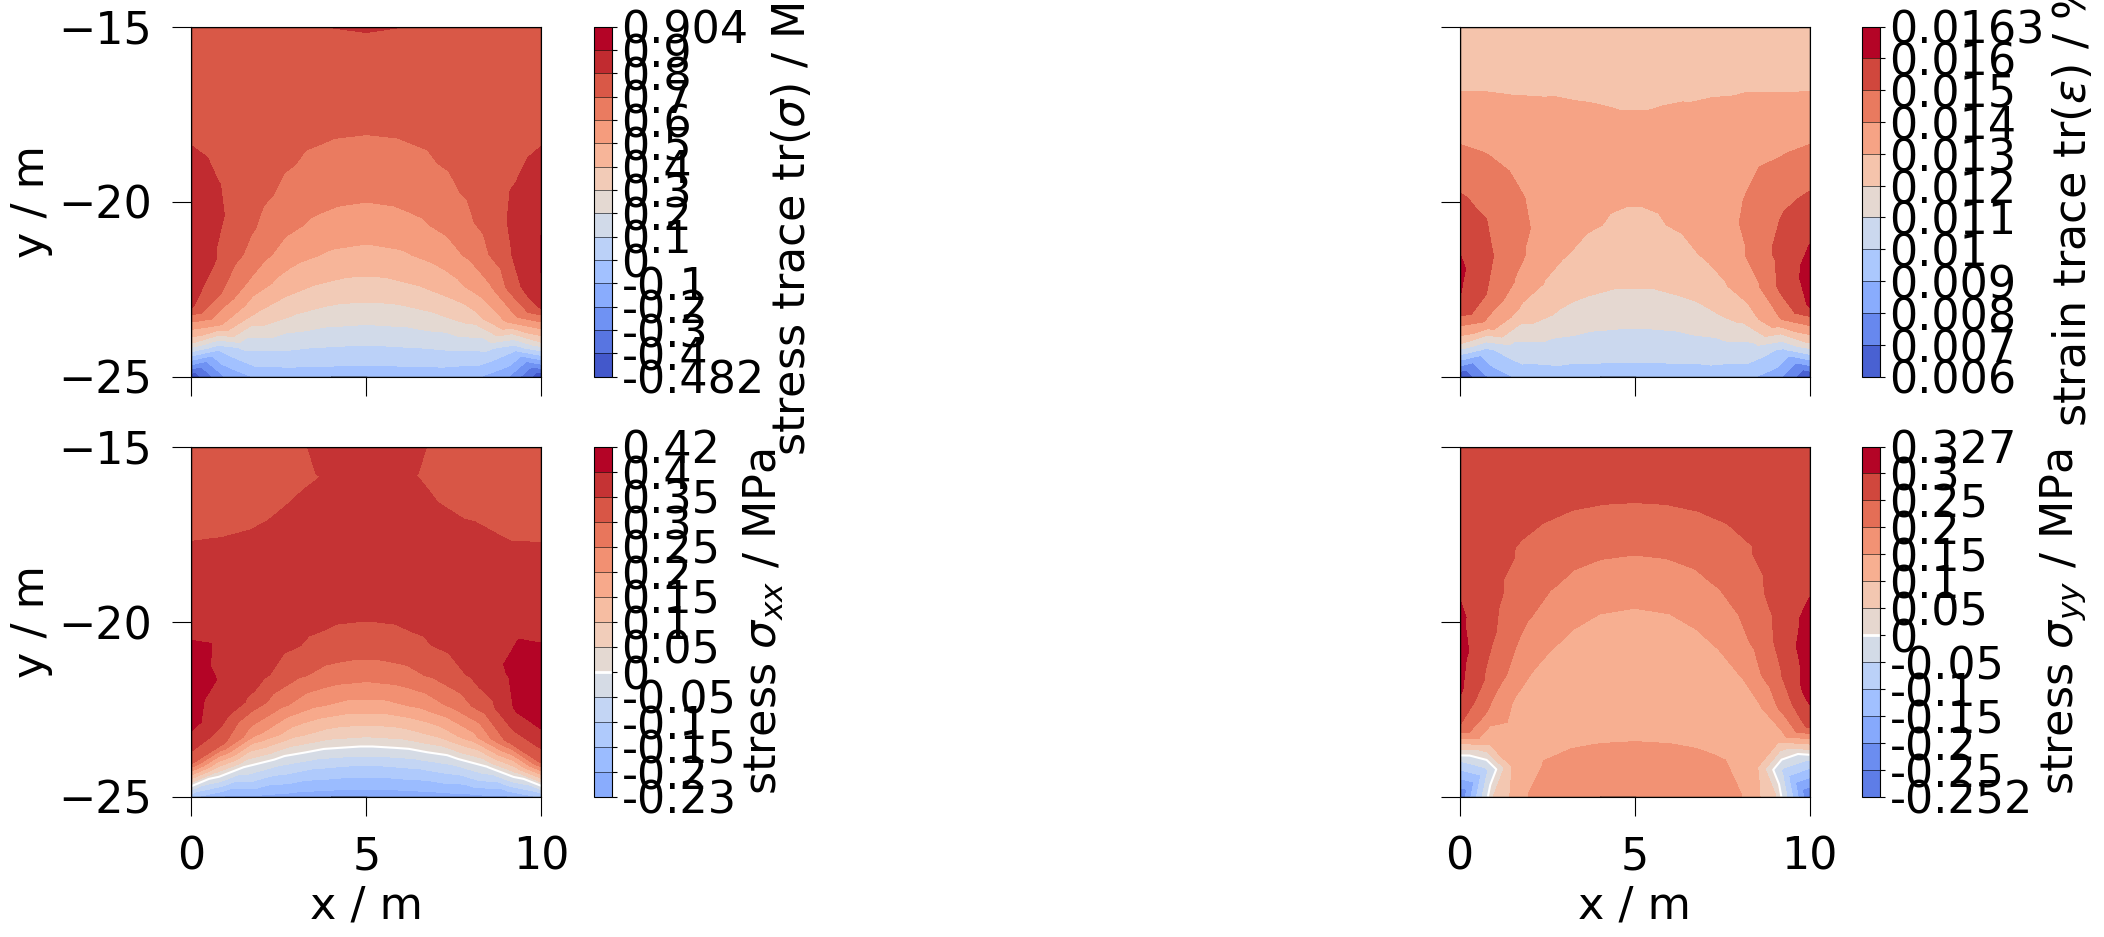

In [10]:
#graph in python

displacement = ot.variables.displacement.replace(output_unit="mm")
mesh.plot_contourf(displacement)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[30, 10], sharex=True, sharey=True)

mesh.plot_contourf(ot.variables.stress.trace, fig, axs[0,0])
mesh.plot_contourf(ot.variables.strain.trace, fig, axs[0,1])
mesh.plot_contourf(ot.variables.stress["xx"], fig, axs[1,0])
mesh.plot_contourf(ot.variables.stress["yy"], fig, axs[1,1])

plt.show()
fig.tight_layout()


# 2D Fracture and Internal modified ID

In [28]:
MSH_FILE = MESH_DIR / "rectangle_frac_2d.msh"


create_rectangle_frac_mesh(
        MSH_FILE,
        width=10.0,
        height=10.0,
        mesh_size=1.0,
        center_z=-20.0,
        mode="BC")
meshes_bc = ot.meshes_from_gmsh(MSH_FILE,  dim=[0,1], log=False) 
for name, mesh in meshes_bc.items():
    vtu_path = MESH_DIR / f"{name}_fracture.vtu"
    pv.save_meshio(vtu_path, mesh)
    print(f"Saved {vtu_path}")
    

create_rectangle_frac_mesh(
        MSH_FILE,
        width=10.0,
        height=10.0,
        mesh_size=1.0,
        center_z=-20.0,
        mode="domain")
meshes_m= ot.meshes_from_gmsh(MSH_FILE,  dim=[1,2], log=False)
for name, mesh in meshes_m.items():
    vtu_path = MESH_DIR / f"{name}_fracture.vtu"
    pv.save_meshio(vtu_path, mesh)
    print(f"Saved {vtu_path}")


Saved _out/mesh/domain_fracture.vtu
Saved _out/mesh/physical_group_p4_fracture.vtu
Saved _out/mesh/physical_group_p3_fracture.vtu
Saved _out/mesh/physical_group_top_fracture.vtu
Saved _out/mesh/physical_group_bottom_fracture.vtu
Saved _out/mesh/physical_group_right_fracture.vtu
Saved _out/mesh/physical_group_left_fracture.vtu

Saved _out/mesh/domain_fracture.vtu
Saved _out/mesh/physical_group_fracture_fracture.vtu
Saved _out/mesh/physical_group_top_surf_fracture.vtu
Saved _out/mesh/physical_group_bot_surf_fracture.vtu


# 2D Plot of fracture and Modified material ID

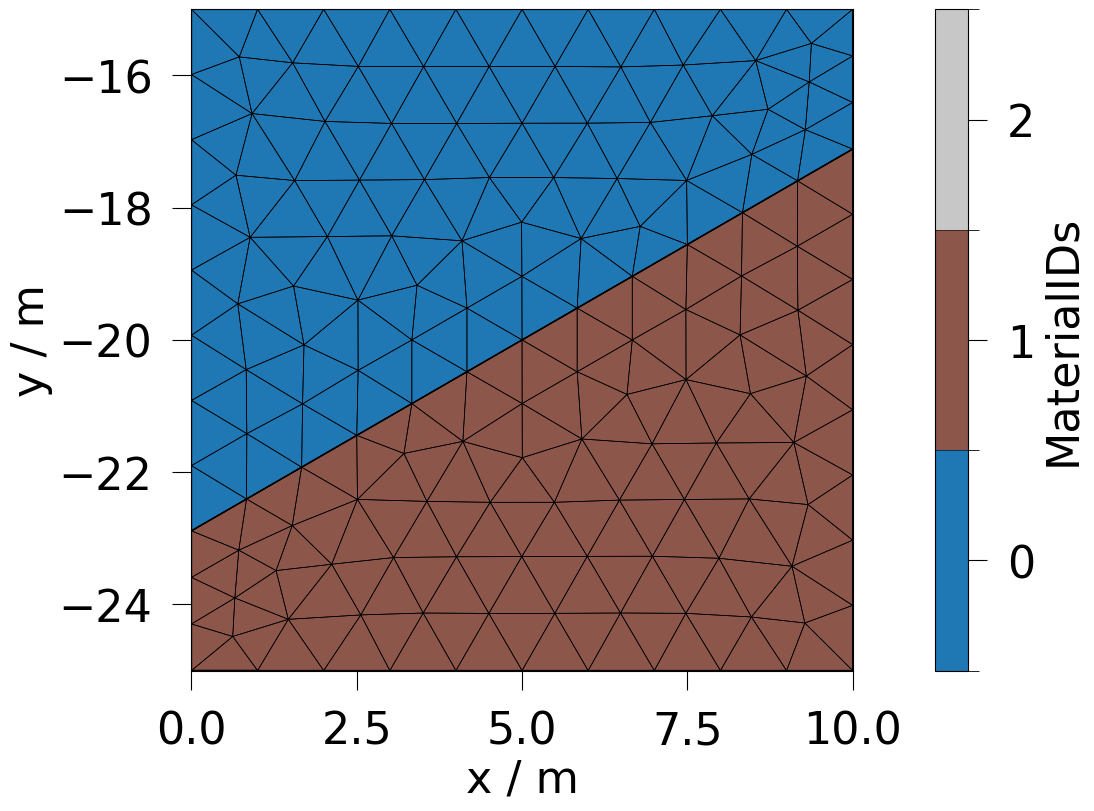

In [29]:
#Domain graph
fig = meshes_m["domain"].plot_contourf(
    "MaterialIDs",
    figsize=(12, 8),
    dpi=100,
    cmap="tab20",
    alpha=0.3,
    linewidth=0,
)
plt.show()


# 2D Fracture OGS and Python plot results

In [31]:
!NodeReordering -o ./_out/mesh/domain_fracture.vtu -i ./_out/mesh/domain_fracture.vtu 
!identifySubdomains -f -m ./_out/mesh/domain_fracture.vtu -- ./_out/mesh/physical_group_p4_fracture.vtu ./_out/mesh/physical_group_top_fracture.vtu ./_out/mesh/physical_group_bottom_fracture.vtu 

[2025-08-04 14:49:03.857] [ogs] [info] Reordering nodes... 
[2025-08-04 14:49:03.858] [ogs] [info] Corrected 0 elements.
[2025-08-04 14:49:03.861] [ogs] [info] VTU file written.
[2025-08-04 14:49:04.039] [ogs] [info] Mesh reading time: 0.007444 s
[2025-08-04 14:49:04.040] [ogs] [info] MeshNodeSearcher construction time: 1.6e-05 s
[2025-08-04 14:49:04.040] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1e-06 s
[2025-08-04 14:49:04.040] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_p4_fracture' and it is equal to the newly computed values.
[2025-08-04 14:49:04.040] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 2.5e-05 s
[2025-08-04 14:49:04.040] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 2e-06 s
[2025-08-04 14:49:04.040] [ogs] [info] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_top_fracture' and it is equal to t

In [32]:
!ogs SD_joint.prj -m ./_out/mesh -o ./_out/

info: OGS started on 2025-08-04 14:49:07+0200 in serial mode.
info: This is OpenGeoSys-6 version 6.5.5-152-g476ff5cf. Log version: 2, Log level: info.
info: Eigen use 1 threads
info: Reading project file SD_joint.prj.
info: readRasters ...
info: readRasters done
info: ConstantParameter: E
info: ConstantParameter: nu
info: ConstantParameter: Kn
info: ConstantParameter: Ks
info: ConstantParameter: displacement0
info: ConstantParameter: aperture0
info: ConstantParameter: load
info: ConstantParameter: zero_u
info: No source terms for process variable 'displacement' found.
info: No source terms for process variable 'displacement_jump1' found.
info: Initialize processes.
info: Time step #0 started. Time: 0. Step size: 0.
info: [time] Output of timestep 0 took 0.005876 s.
info: Time step #0 took 0.006269 s.
info: Solve processes.
info: Time step #1 started. Time: 1. Step size: 1.
info: Solving process #0 started.
info: Iteration #1 started.
info: [time] Assembly took 0.000729 s.
info: [time] 

# 3D mesh

In [15]:
cube_file = MESH_DIR / "cube_3d.msh"

create_cube_mesh(
        cube_file,        
        width=10.0,
        height=10.0,
        thickness=10.0,
        mesh_size=1.0,
        center_z=-20.0  
    )

cube_meshes = ot.meshes_from_gmsh(cube_file, log=False)
for name, mesh in cube_meshes.items():
    vtu = MESH_DIR / f"cube_{name}.vtu"
    pv.save_meshio(vtu, mesh)
    print(f"Saved {vtu}")


Saved _out/mesh/cube_domain.vtu
Saved _out/mesh/cube_physical_group_points.vtu
Saved _out/mesh/cube_physical_group_edges.vtu
Saved _out/mesh/cube_physical_group_bottom.vtu
Saved _out/mesh/cube_physical_group_top.vtu
Saved _out/mesh/cube_physical_group_front.vtu
Saved _out/mesh/cube_physical_group_back.vtu
Saved _out/mesh/cube_physical_group_left.vtu
Saved _out/mesh/cube_physical_group_right.vtu
Saved _out/mesh/cube_physical_group_volume.vtu


## 3D Plot 

/Volumes/OpenGeoSys/build/release/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1846: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
/Volumes/OpenGeoSys/build/release/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1852: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
/Volumes/OpenGeoSys/build/release/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1858: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(


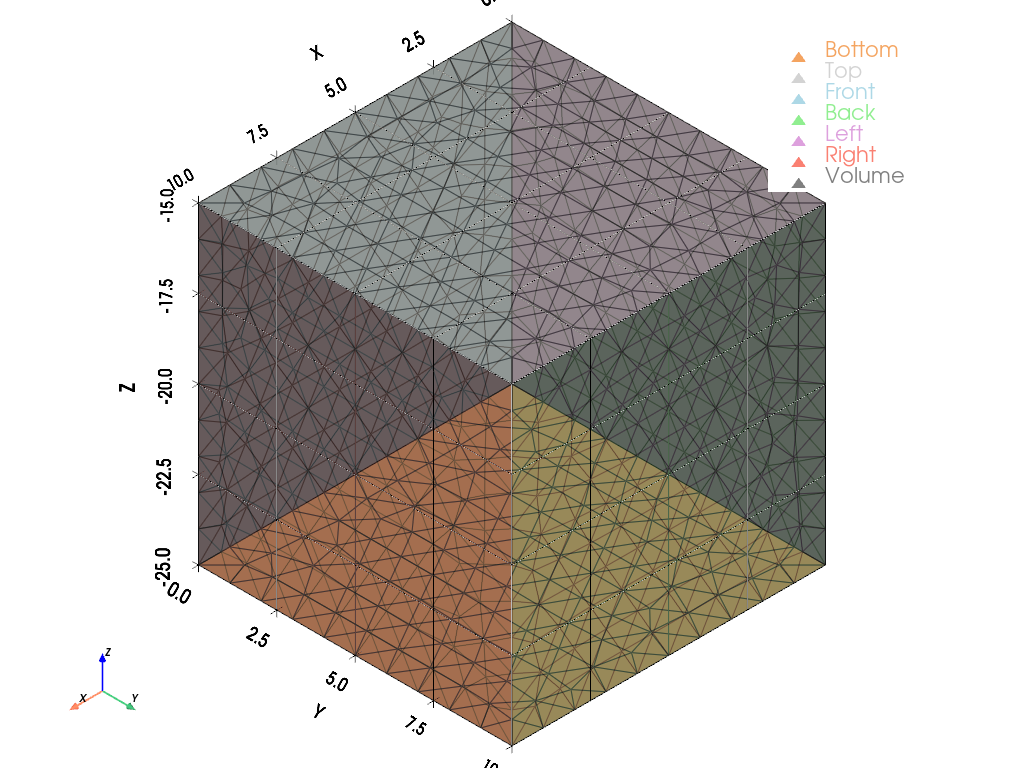

In [16]:
try:
    pv.set_jupyter_backend("static")
except Exception as e:
    print("PyVista backend not set:", e)


faces = {
    "bottom": pv.read(f"{MESH_DIR}/cube_physical_group_bottom.vtu"),
    "top":    pv.read(f"{MESH_DIR}/cube_physical_group_top.vtu"),
    "front":  pv.read(f"{MESH_DIR}/cube_physical_group_front.vtu"),
    "back":   pv.read(f"{MESH_DIR}/cube_physical_group_back.vtu"),
    "left":   pv.read(f"{MESH_DIR}/cube_physical_group_left.vtu"),
    "right":  pv.read(f"{MESH_DIR}/cube_physical_group_right.vtu"),
}
vol    = pv.read(f"{MESH_DIR}/cube_physical_group_volume.vtu")

plotter = pv.Plotter(off_screen=True)

face_colors = {
    "bottom": "sandybrown",
    "top":    "lightgray",
    "front":  "lightblue",
    "back":   "lightgreen",
    "left":   "plum",
    "right":  "salmon",
}
for name, mesh in faces.items():
    plotter.add_mesh(
        mesh,
        color=face_colors[name],
        opacity=0.7,
        show_edges=True,
        label=name.capitalize(),
    )

try:
    vol_surf = vol.extract_surface()
except AttributeError:
    vol_surf = vol
plotter.add_mesh(
    vol_surf,
    style="wireframe",
    color="gray",
    opacity=0.2,
    label="Volume",
)

plotter.show_bounds(
    grid="front",       
    location="outer",   
    all_edges=True,     
    ticks="both",       
    xlabel="X",        
    ylabel="Y",         
    zlabel="Z",         
    font_size=14
)

plotter.add_legend(bcolor="w")
plotter.show_axes()
plotter.enable_parallel_projection()
plotter.view_isometric()
plotter.show()

# 3D OGS and python plot results

In [17]:
!ogs SD_init_3D.prj -m ./_out/mesh -o ./_out/

info: OGS started on 2025-08-04 14:44:22+0200 in serial mode.
info: This is OpenGeoSys-6 version 6.5.5-152-g476ff5cf. Log version: 2, Log level: info.
info: Eigen use 1 threads
info: Reading project file SD_init_3D.prj.
info: readRasters ...
info: readRasters done
info: ConstantParameter: E
info: ConstantParameter: nu
info: ConstantParameter: displacement0
info: ConstantParameter: zero
info: ConstantParameter: T0
info: FunctionParameter: sigma0
info: FunctionParameter: geo_stress
info: No source terms for process variable 'displacement' found.
info: Threads used for ParallelVectorMatrixAssembler: 1. This is the default when OGS_ASM_THREADS environment variable is not set.
info: SmallDeformation process initializeSubmeshOutput().
info: Initialize processes.
info: Time step #0 started. Time: 0. Step size: 0.
info: [time] Output of timestep 0 took 0.039664 s.
info: Time step #0 took 0.042995 s.
info: Solve processes.
info: Time step #1 started. Time: 10. Step size: 10.
info: Solving proce

In [18]:

ms = ot.MeshSeries(f'{OUT_DIR}/init.pvd')
mesh = ms[-1]

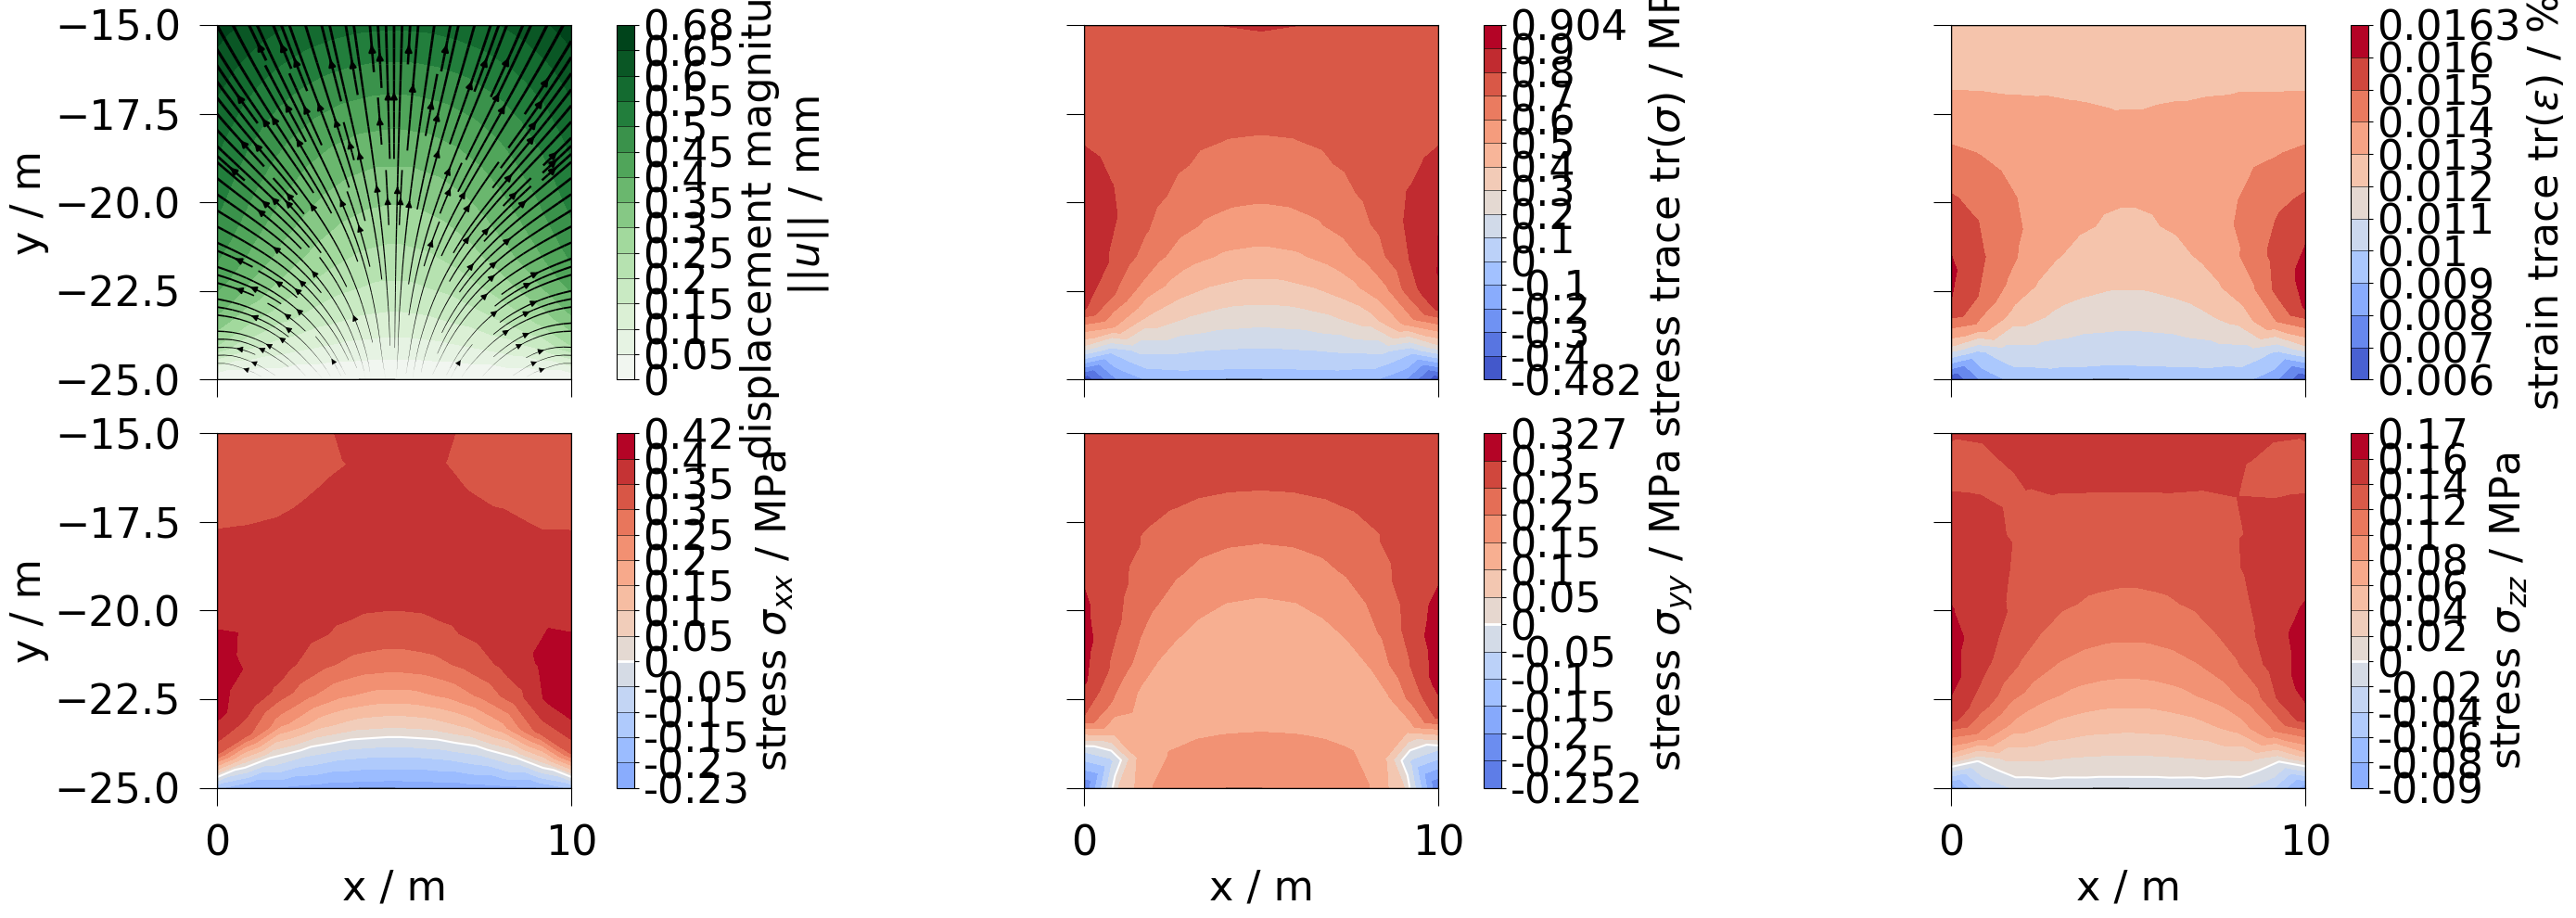

In [19]:


fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[30, 10], sharex=True, sharey=True)
displacement = ot.variables.displacement.replace(output_unit="mm")
mesh.plot_contourf(displacement, fig, axs[0,0])
mesh.plot_contourf(ot.variables.stress.trace, fig, axs[0,1])
mesh.plot_contourf(ot.variables.strain.trace, fig, axs[0,2])

mesh.plot_contourf(ot.variables.stress["xx"], fig, axs[1,0])
mesh.plot_contourf(ot.variables.stress["yy"], fig, axs[1,1])
mesh.plot_contourf(ot.variables.stress["zz"], fig, axs[1,2])
fig.tight_layout()



In [20]:
!NodeReordering -o ./_out/mesh/cube_domain.vtu -i ./_out/mesh/cube_domain.vtu 

[2025-08-04 14:44:28.001] [ogs] [info] Reordering nodes... 
[2025-08-04 14:44:28.003] [ogs] [info] Corrected 0 elements.
[2025-08-04 14:44:28.007] [ogs] [info] VTU file written.


In [21]:
!ogs SD_init_3D.prj -m ./_out/mesh -o ./_out/

info: OGS started on 2025-08-04 14:44:28+0200 in serial mode.
info: This is OpenGeoSys-6 version 6.5.5-152-g476ff5cf. Log version: 2, Log level: info.
info: Eigen use 1 threads
info: Reading project file SD_init_3D.prj.
info: readRasters ...
info: readRasters done
info: ConstantParameter: E
info: ConstantParameter: nu
info: ConstantParameter: displacement0
info: ConstantParameter: zero
info: ConstantParameter: T0
info: FunctionParameter: sigma0
info: FunctionParameter: geo_stress
info: No source terms for process variable 'displacement' found.
info: Threads used for ParallelVectorMatrixAssembler: 1. This is the default when OGS_ASM_THREADS environment variable is not set.
info: SmallDeformation process initializeSubmeshOutput().
info: Initialize processes.
info: Time step #0 started. Time: 0. Step size: 0.
info: [time] Output of timestep 0 took 0.029655 s.
info: Time step #0 took 0.033126 s.
info: Solve processes.
info: Time step #1 started. Time: 10. Step size: 10.
info: Solving proce